In [ ]:
# 필요한 라이브러리 import
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
import random
import os


#fixed random seed
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

# train 데이터 불러오기
train_data = pd.read_csv('train.csv')
print("Train 데이터:")
print(train_data.head())

# international trade 데이터 불러오기
trade_data = pd.read_csv('international_trade.csv')
print("\nInternational Trade 데이터:")
print(trade_data.head())

Train 데이터:
                ID   timestamp item corporation location  supply(kg)  \
0  TG_A_J_20190101  2019-01-01   TG           A        J         0.0   
1  TG_A_J_20190102  2019-01-02   TG           A        J         0.0   
2  TG_A_J_20190103  2019-01-03   TG           A        J     60601.0   
3  TG_A_J_20190104  2019-01-04   TG           A        J     25000.0   
4  TG_A_J_20190105  2019-01-05   TG           A        J     32352.0   

   price(원/kg)  
0          0.0  
1          0.0  
2       1728.0  
3       1408.0  
4       1250.0  

International Trade 데이터:
        기간                        품목명   수출 중량  수출 금액    수입 중량  수입 금액  무역수지
0  2019-01  토마토(신선한 것이나 냉장한 것으로 한정한다)  356571    990        0      0   990
1  2019-01                         양파  821330    222  4003206   1118  -896
2  2019-01                         쪽파      60      1    93405    128  -127
3  2019-01       꽃양배추와 브로콜리(broccoli)     160      1   638913    563  -562
4  2019-01                  방울다다기 양배추       0      0 

In [ ]:
#시계열 특성을 학습에 반영하기 위해 timestamp를 월, 일, 시간으로 나눕니다
train_data['year'] = train_data['timestamp'].apply(lambda x : int(x[0:4]))
train_data['month'] = train_data['timestamp'].apply(lambda x : int(x[5:7]))
train_data['day'] = train_data['timestamp'].apply(lambda x : int(x[8:10]))

trade_data['year'] = trade_data['기간'].apply(lambda x : int(x[0:4]))
trade_data['month'] = trade_data['기간'].apply(lambda x : int(x[5:7]))
trade_data['day'] = trade_data['기간'].apply(lambda x: int(x[8:10]) if x[8:10] else 0)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59397 entries, 0 to 59396
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           59397 non-null  object 
 1   timestamp    59397 non-null  object 
 2   item         59397 non-null  object 
 3   corporation  59397 non-null  object 
 4   location     59397 non-null  object 
 5   supply(kg)   59397 non-null  float64
 6   price(원/kg)  59397 non-null  float64
 7   year         59397 non-null  int64  
 8   month        59397 non-null  int64  
 9   day          59397 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 4.5+ MB


In [ ]:
# 데이터 파악

train_data['item'].value_counts()

TG    15230
BC    13707
RD    12184
CR    10661
CB     7615
Name: item, dtype: int64

In [ ]:
trade_data['품목명'].value_counts()

감귤                                                                               50
포포(papaw)[파파야(papaya)]                                                           50
레몬[시트러스 리몬(Citrus limon)ㆍ시트러스 리머늄(Citrus limonum)]                               50
그레이프프루트(grapefruit)와 포멜로(pomelo)                                                 50
오렌지                                                                              50
망고(mango)                                                                        50
파인애플                                                                             50
무화과                                                                              50
대추야자                                                                             50
사과                                                                               50
오이류(신선한 것이나 냉장한 것으로 한정한다)                                                        50
당근                                                                          

In [ ]:
trade_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1274 entries, 0 to 1273
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   기간      1274 non-null   object
 1   품목명     1274 non-null   object
 2   수출 중량   1274 non-null   int64 
 3   수출 금액   1274 non-null   int64 
 4   수입 중량   1274 non-null   int64 
 5   수입 금액   1274 non-null   int64 
 6   무역수지    1274 non-null   int64 
 7   year    1274 non-null   int64 
 8   month   1274 non-null   int64 
 9   day     1274 non-null   int64 
dtypes: int64(8), object(2)
memory usage: 99.7+ KB


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59397 entries, 0 to 59396
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           59397 non-null  object 
 1   timestamp    59397 non-null  object 
 2   item         59397 non-null  object 
 3   corporation  59397 non-null  object 
 4   location     59397 non-null  object 
 5   supply(kg)   59397 non-null  float64
 6   price(원/kg)  59397 non-null  float64
 7   year         59397 non-null  int64  
 8   month        59397 non-null  int64  
 9   day          59397 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 4.5+ MB


In [ ]:
# 데이터 전처리 _ 결측치 정제

pd.isna(train_data).sum()

ID             0
timestamp      0
item           0
corporation    0
location       0
supply(kg)     0
price(원/kg)    0
year           0
month          0
day            0
dtype: int64

In [ ]:
pd.isna(trade_data).sum()

기간       0
품목명      0
수출 중량    0
수출 금액    0
수입 중량    0
수입 금액    0
무역수지     0
year     0
month    0
day      0
dtype: int64

In [ ]:
# trade 전처리- 필요 행만 추출

ex_trade=trade_data[trade_data.품목명.str.contains('감귤|브로콜리|무|당근|양배추')]
ex_trade.loc[ex_trade['품목명']=='꽃양배추와 브로콜리(broccoli)','품목명'] ='브로콜리'
ex_trade.loc[ex_trade['품목명']=='방울다다기 양배추','품목명'] ='양배추'
ex_trade=ex_trade[ex_trade['품목명']!='무화과']

ex_trade

,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지,year,month,day
3,2019-01,브로콜리,160,1,638913,563,-562,2019,1,0
4,2019-01,양배추,0,0,7580,38,-38,2019,1,0
5,2019-01,양배추,184650,94,395802,90,4,2019,1,0
8,2019-01,당근,23150,22,7466150,2955,-2934,2019,1,0
17,2019-01,감귤,58368,172,0,0,172,2019,1,0
...,...,...,...,...,...,...,...,...,...,...
1249,2023-02,양배추,71,1,10362,55,-55,2023,2,0
1250,2023-02,양배추,13188,13,377456,104,-91,2023,2,0
1253,2023-02,당근,22510,20,9260020,3758,-3737,2023,2,0
1254,2023-02,순무,4000,4,2,0,4,2023,2,0


In [ ]:
# train전처리 - 가격변화량 컬럼 생성
train_data['timestamp'] = pd.to_datetime(train_data['timestamp'])
train_data['price_var_total'] = train_data['price(원/kg)'] - train_data['price(원/kg)'].shift(1)
train_data['price_var_total'].fillna(0, inplace=True)

# TIMESTAMP 실수형 컬럼 생성
train_data['timestamp_float'] = pd.to_datetime(train_data['timestamp']).astype(int) / 10**9  # POSIX 시간으로 변환 후 초 단위로 나눔


print(train_data)

                    ID  timestamp item corporation location  supply(kg)  \
0      TG_A_J_20190101 2019-01-01   TG           A        J         0.0   
1      TG_A_J_20190102 2019-01-02   TG           A        J         0.0   
2      TG_A_J_20190103 2019-01-03   TG           A        J     60601.0   
3      TG_A_J_20190104 2019-01-04   TG           A        J     25000.0   
4      TG_A_J_20190105 2019-01-05   TG           A        J     32352.0   
...                ...        ...  ...         ...      ...         ...   
59392  RD_F_J_20230227 2023-02-27   RD           F        J    452440.0   
59393  RD_F_J_20230228 2023-02-28   RD           F        J    421980.0   
59394  RD_F_J_20230301 2023-03-01   RD           F        J    382980.0   
59395  RD_F_J_20230302 2023-03-02   RD           F        J    477220.0   
59396  RD_F_J_20230303 2023-03-03   RD           F        J    427520.0   

       price(원/kg)  year  month  day  price_var_total  timestamp_float  
0              0.0  2019  

<Axes: xlabel='supply(kg)', ylabel='price(원/kg)'>

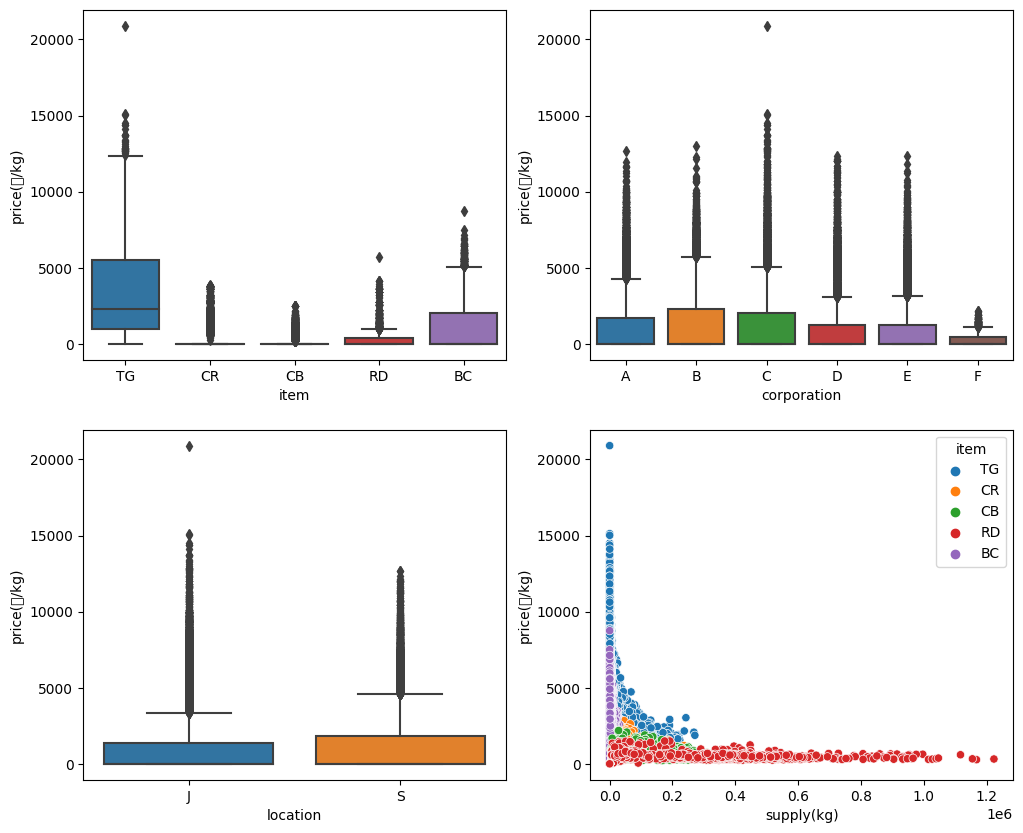

In [ ]:
#데이터 파악 <train>

# 이상치 확인

fig, axes = plt.subplots(2, 2, figsize=(12, 10))


sns.boxplot(data=train_data,x='item',y='price(원/kg)',ax=axes[0, 0])
sns.boxplot(data=train_data,x='corporation',y='price(원/kg)',ax=axes[0, 1])
sns.boxplot(data=train_data,x='location',y='price(원/kg)',ax=axes[1, 0])
sns.scatterplot(data=train_data,x='supply(kg)',y='price(원/kg)',hue='item',ax=axes[1, 1])

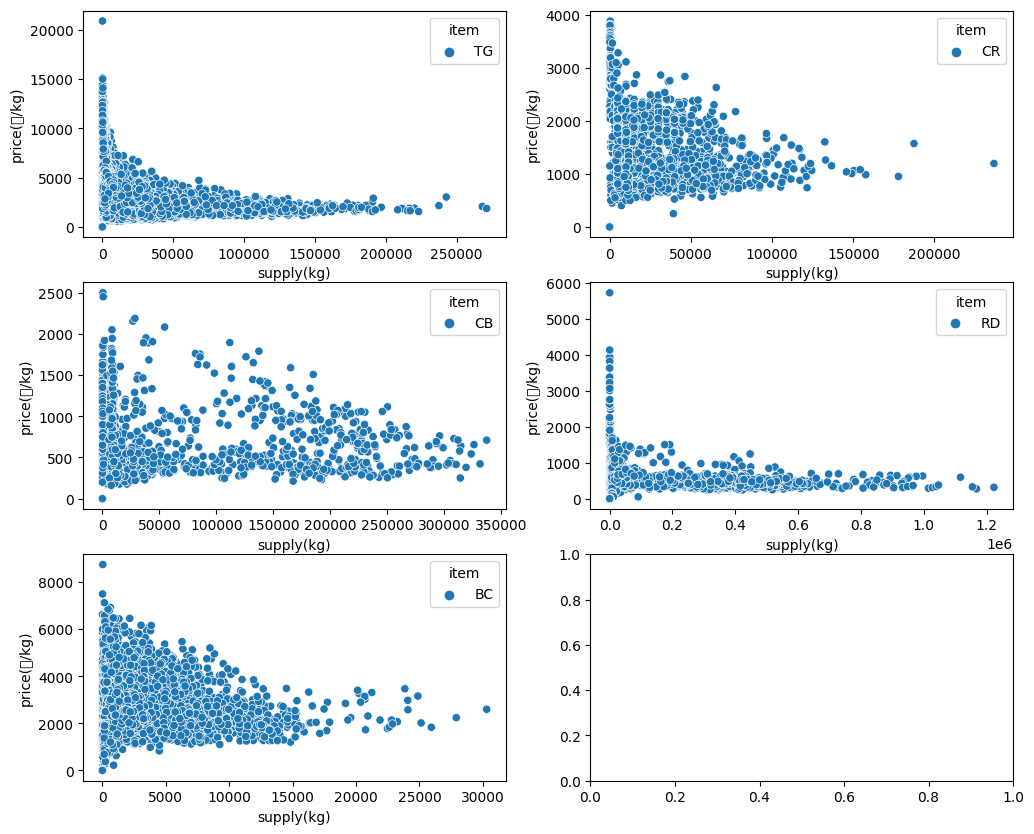

In [ ]:
# 색상 팔레트 리스트
custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

# 품목별 산점도 관찰
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

sns.scatterplot(data=train_data[train_data['item']=='TG'], x='supply(kg)', y='price(원/kg)', hue='item', palette=custom_palette, ax=axes[0, 0])
sns.scatterplot(data=train_data[train_data['item']=='CR'], x='supply(kg)', y='price(원/kg)', hue='item', palette=custom_palette, ax=axes[0, 1])
sns.scatterplot(data=train_data[train_data['item']=='CB'], x='supply(kg)', y='price(원/kg)', hue='item', palette=custom_palette, ax=axes[1, 0])
sns.scatterplot(data=train_data[train_data['item']=='RD'], x='supply(kg)', y='price(원/kg)', hue='item', palette=custom_palette, ax=axes[1, 1])
sns.scatterplot(data=train_data[train_data['item']=='BC'], x='supply(kg)', y='price(원/kg)', hue='item', palette=custom_palette, ax=axes[2, 0])


plt.show()

<Axes: xlabel='day', ylabel='price_var_total'>

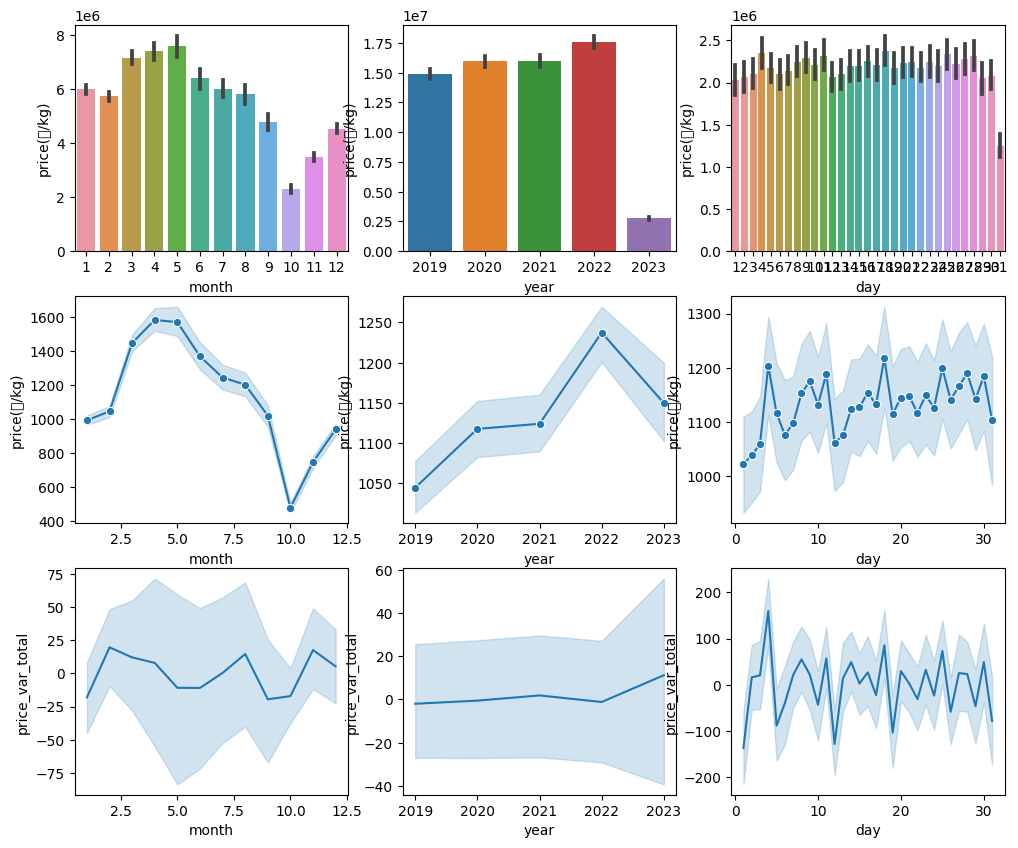

In [ ]:
# [train] 시계열 변화 관찰

fig, axes = plt.subplots(3, 3, figsize=(12, 10))

# 합계
sns.barplot(data=train_data, x='month',y='price(원/kg)',ax=axes[0,0],estimator=sum)
sns.barplot(data=train_data, x='year',y='price(원/kg)',ax=axes[0,1],estimator=sum)
sns.barplot(data=train_data, x='day',y='price(원/kg)',ax=axes[0,2],estimator=sum)

# 평균
sns.lineplot(data=train_data, x='month',y='price(원/kg)', marker='o',ax=axes[1,0])
sns.lineplot(data=train_data, x='year',y='price(원/kg)', marker='o',ax=axes[1,1])
sns.lineplot(data=train_data, x='day',y='price(원/kg)', marker='o',ax=axes[1,2])

# 변화량
sns.lineplot(data=train_data, x='month',y='price_var_total', ax=axes[2,0])
sns.lineplot(data=train_data, x='year',y='price_var_total', ax=axes[2,1])
sns.lineplot(data=train_data, x='day',y='price_var_total',ax=axes[2,2])

Text(0.5, 1.0, 'price variance per timestamp')

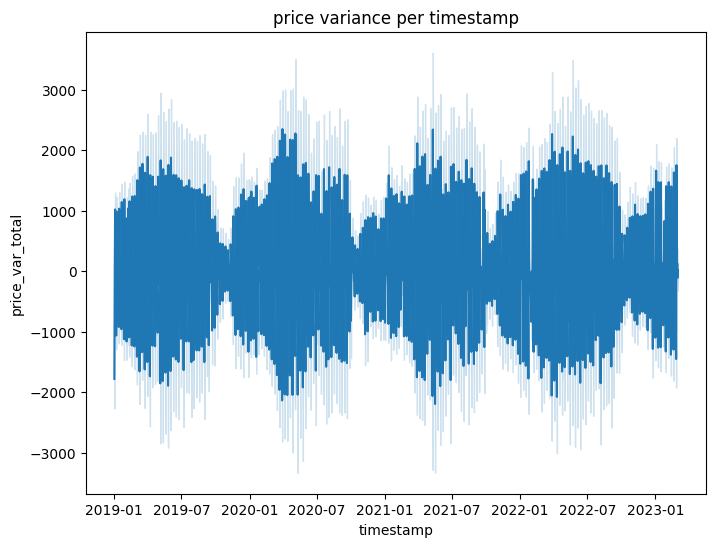

In [ ]:
plt.figure(figsize=(8,6))
sns.lineplot(data=train_data, x='timestamp',y='price_var_total')
plt.title('price variance per timestamp')

In [ ]:
#trade 원화로 환산하기
won = pd.read_csv('환율.csv')
print("환율 데이터:")
print(won.head())

won.info()

환율 데이터:
        변환       원자료     원자료.1
0  2019/01  1,121.72  1,112.70
1  2019/02  1,123.66  1,124.70
2  2019/03  1,131.88  1,135.10
3  2019/04  1,142.79  1,168.20
4  2019/05  1,184.93  1,190.90
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   변환      51 non-null     object
 1   원자료     51 non-null     object
 2   원자료.1   51 non-null     object
dtypes: object(3)
memory usage: 1.3+ KB


In [ ]:

#date time 으로 바꾸기
won['변환'] = pd.to_datetime(won['변환'])
ex_trade['기간']=pd.to_datetime(ex_trade['기간'])

# '원자료' 컬럼의 ',' 제거 및 숫자로 변환
won['원자료'] = won['원자료'].str.replace(',', '').astype(float)

In [ ]:
# '기간' 컬럼을 기준으로 ex_trade와 won 데이터프레임을 합침
ex_trade_m = pd.merge(ex_trade, won, left_on='기간', right_on='변환', how='left')

# '변환' 컬럼은 필요 없으므로 삭제
ex_trade_m = ex_trade_m.drop('변환', axis=1)

# 확인
print(ex_trade_m)

            기간   품목명   수출 중량  수출 금액    수입 중량  수입 금액  무역수지  year  month  day  \
0   2019-01-01  브로콜리     160      1   638913    563  -562  2019      1    0   
1   2019-01-01   양배추       0      0     7580     38   -38  2019      1    0   
2   2019-01-01   양배추  184650     94   395802     90     4  2019      1    0   
3   2019-01-01    당근   23150     22  7466150   2955 -2934  2019      1    0   
4   2019-01-01    감귤   58368    172        0      0   172  2019      1    0   
..         ...   ...     ...    ...      ...    ...   ...   ...    ...  ...   
251 2023-02-01   양배추      71      1    10362     55   -55  2023      2    0   
252 2023-02-01   양배추   13188     13   377456    104   -91  2023      2    0   
253 2023-02-01    당근   22510     20  9260020   3758 -3737  2023      2    0   
254 2023-02-01    순무    4000      4        2      0     4  2023      2    0   
255 2023-02-01    감귤    6895     34    27765     98   -64  2023      2    0   

         원자료     원자료.1  
0    1121.72  1,112.70  
1

In [ ]:
# 컬럼생성
ex_trade_m['수출금액_원']=ex_trade_m['수출 금액']*ex_trade_m['원자료']
ex_trade_m['수입금액_원']=ex_trade_m['수입 금액']*ex_trade_m['원자료']

ex_trade_m['수출금액_원(kg)']=ex_trade_m['수출금액_원']/ex_trade_m['수출 중량']
ex_trade_m['수입금액_원(kg)']=ex_trade_m['수입금액_원']/ex_trade_m['수입 중량']
ex_trade_m['수출금액_원(kg)'].fillna(0, inplace=True)
ex_trade_m['수입금액_원(kg)'].fillna(0, inplace=True)


# 확인
print(ex_trade_m[['수입 금액', '원자료', '수출금액_원','수입금액_원','수출금액_원(kg)']])

     수입 금액      원자료     수출금액_원      수입금액_원  수출금액_원(kg)
0      563  1121.72    1121.72   631528.36    7.010750
1       38  1121.72       0.00    42625.36    0.000000
2       90  1121.72  105441.68   100954.80    0.571035
3     2955  1121.72   24677.84  3314682.60    1.065997
4        0  1121.72  192935.84        0.00    3.305507
..     ...      ...        ...         ...         ...
251     55  1276.54    1276.54    70209.70   17.979437
252    104  1276.54   16595.02   132760.16    1.258342
253   3758  1276.54   25530.80  4797237.32    1.134198
254      0  1276.54    5106.16        0.00    1.276540
255     98  1276.54   43402.36   125100.92    6.294759

[256 rows x 5 columns]


In [ ]:
# trade 가격변화량 컬럼 생성
ex_trade_m['price_var_ex'] = ex_trade_m['수출금액_원(kg)'] - ex_trade_m['수출금액_원(kg)'].shift(1)
ex_trade_m['price_var_ex'].fillna(0, inplace=True)
ex_trade_m['price_var_im'] = ex_trade_m['수입금액_원(kg)'] - ex_trade_m['수입금액_원(kg)'].shift(1)
ex_trade_m['price_var_im'].fillna(0, inplace=True)


print(ex_trade_m)

            기간   품목명   수출 중량  수출 금액    수입 중량  수입 금액  무역수지  year  month  day  \
0   2019-01-01  브로콜리     160      1   638913    563  -562  2019      1    0   
1   2019-01-01   양배추       0      0     7580     38   -38  2019      1    0   
2   2019-01-01   양배추  184650     94   395802     90     4  2019      1    0   
3   2019-01-01    당근   23150     22  7466150   2955 -2934  2019      1    0   
4   2019-01-01    감귤   58368    172        0      0   172  2019      1    0   
..         ...   ...     ...    ...      ...    ...   ...   ...    ...  ...   
251 2023-02-01   양배추      71      1    10362     55   -55  2023      2    0   
252 2023-02-01   양배추   13188     13   377456    104   -91  2023      2    0   
253 2023-02-01    당근   22510     20  9260020   3758 -3737  2023      2    0   
254 2023-02-01    순무    4000      4        2      0     4  2023      2    0   
255 2023-02-01    감귤    6895     34    27765     98   -64  2023      2    0   

         원자료     원자료.1     수출금액_원      수입금액_원  수출금액

In [ ]:
# 품목명 바꾸기
ex_trade_m['품목명'] = ex_trade_m['품목명'].replace({'당근': 'CR', '브로콜리': 'BC', '순무': 'RD', '감귤': 'TG', '양배추': 'CB'})

# 확인
print(ex_trade_m['품목명'])

0      BC
1      CB
2      CB
3      CR
4      TG
       ..
251    CB
252    CB
253    CR
254    RD
255    TG
Name: 품목명, Length: 256, dtype: object


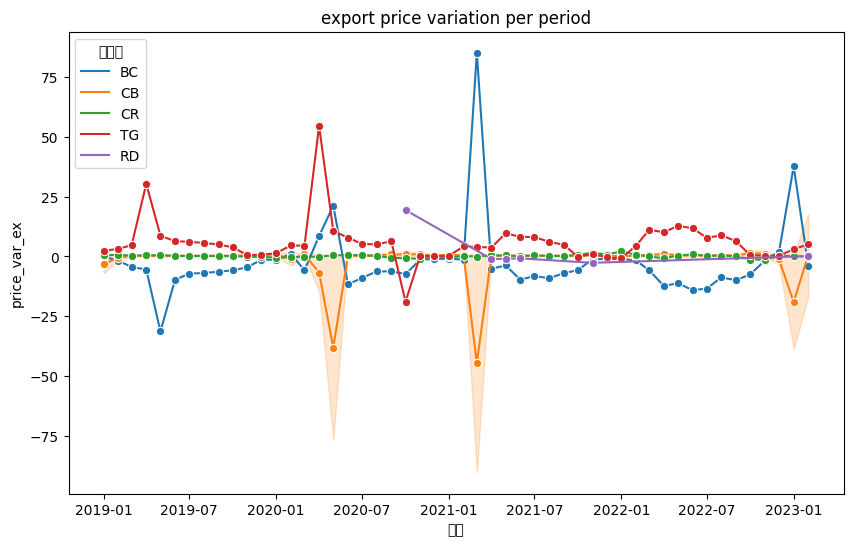

In [ ]:
# 시각화

# Seaborn을 사용하여 '품목명'별로 선 그래프 그리기
plt.figure(figsize=(10, 6))
sns.lineplot(data=ex_trade_m, x='기간', y='price_var_ex', hue='품목명', marker='o')


# 그래프에 제목 추가
plt.title('export price variation per period')

# 그래프 표시
plt.show()

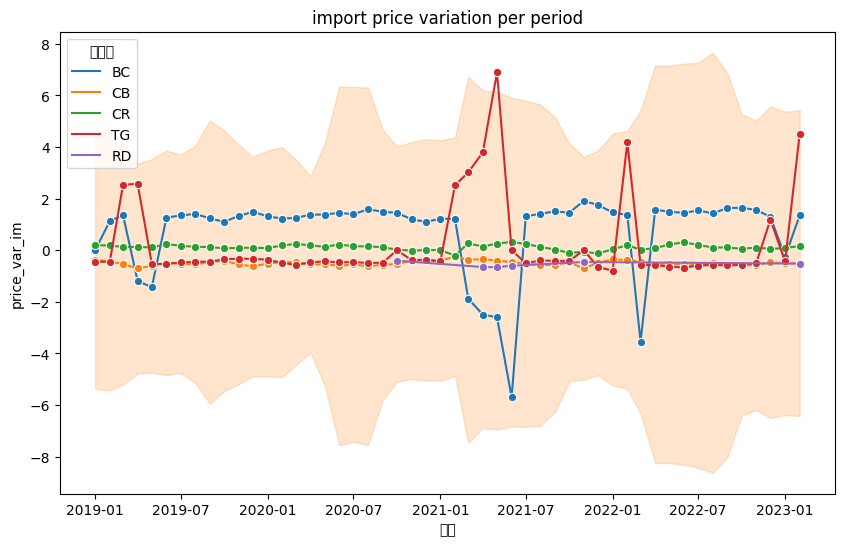

In [ ]:
# 시각화

# Seaborn을 사용하여 '품목명'별로 선 그래프 그리기
plt.figure(figsize=(10, 6))
sns.lineplot(data=ex_trade_m, x='기간', y='price_var_im', hue='품목명', marker='o')


# 그래프에 제목 추가
plt.title('import price variation per period')

# 그래프 표시
plt.show()

                 supply(kg)  price(원/kg)      year     month       day  \
supply(kg)         1.000000    -0.002297  0.024278 -0.120580  0.000161   
price(원/kg)       -0.002297     1.000000  0.029442 -0.076673  0.011755   
year               0.024278     0.029442  1.000000 -0.114541 -0.010426   
month             -0.120580    -0.076673 -0.114541  1.000000  0.014989   
day                0.000161     0.011755 -0.010426  0.014989  1.000000   
price_var_total    0.030861     0.408035  0.000865  0.000051  0.000998   
timestamp_float   -0.005071     0.010796  0.969990  0.129617  0.013240   

                 price_var_total  timestamp_float  
supply(kg)              0.030861        -0.005071  
price(원/kg)             0.408035         0.010796  
year                    0.000865         0.969990  
month                   0.000051         0.129617  
day                     0.000998         0.013240  
price_var_total         1.000000         0.000896  
timestamp_float         0.000896         1.

Text(0.5, 1.0, '변수 간 상관 관계 히트맵')

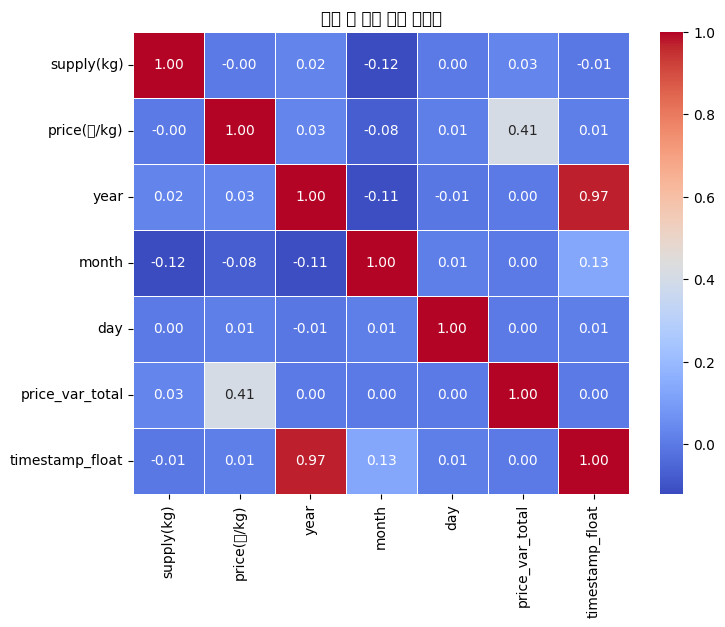

In [ ]:
# 변수간 상관분석 <train>
correlation_matrix=train_data.corr()

# 상관 행렬 출력
print(correlation_matrix)

#히트맵 그리기
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix,annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('변수 간 상관 관계 히트맵')

In [ ]:
# 두 데이터 결합

#년월 컬럼 생성
train_data['TRADETIME']=train_data['timestamp'].dt.to_period('M')
print(train_data)

                    ID  timestamp item corporation location  supply(kg)  \
0      TG_A_J_20190101 2019-01-01   TG           A        J         0.0   
1      TG_A_J_20190102 2019-01-02   TG           A        J         0.0   
2      TG_A_J_20190103 2019-01-03   TG           A        J     60601.0   
3      TG_A_J_20190104 2019-01-04   TG           A        J     25000.0   
4      TG_A_J_20190105 2019-01-05   TG           A        J     32352.0   
...                ...        ...  ...         ...      ...         ...   
59392  RD_F_J_20230227 2023-02-27   RD           F        J    452440.0   
59393  RD_F_J_20230228 2023-02-28   RD           F        J    421980.0   
59394  RD_F_J_20230301 2023-03-01   RD           F        J    382980.0   
59395  RD_F_J_20230302 2023-03-02   RD           F        J    477220.0   
59396  RD_F_J_20230303 2023-03-03   RD           F        J    427520.0   

       price(원/kg)  year  month  day  price_var_total  timestamp_float  \
0              0.0  2019 

In [ ]:
ex_trade_m['기간_1'] = ex_trade_m['기간'].dt.to_period('M')
print(ex_trade_m)

            기간 품목명   수출 중량  수출 금액    수입 중량  수입 금액  무역수지  year  month  day  \
0   2019-01-01  BC     160      1   638913    563  -562  2019      1    0   
1   2019-01-01  CB       0      0     7580     38   -38  2019      1    0   
2   2019-01-01  CB  184650     94   395802     90     4  2019      1    0   
3   2019-01-01  CR   23150     22  7466150   2955 -2934  2019      1    0   
4   2019-01-01  TG   58368    172        0      0   172  2019      1    0   
..         ...  ..     ...    ...      ...    ...   ...   ...    ...  ...   
251 2023-02-01  CB      71      1    10362     55   -55  2023      2    0   
252 2023-02-01  CB   13188     13   377456    104   -91  2023      2    0   
253 2023-02-01  CR   22510     20  9260020   3758 -3737  2023      2    0   
254 2023-02-01  RD    4000      4        2      0     4  2023      2    0   
255 2023-02-01  TG    6895     34    27765     98   -64  2023      2    0   

         원자료     원자료.1     수출금액_원      수입금액_원  수출금액_원(kg)  수입금액_원(kg)  \
0 

In [ ]:
# TRADETIME과 기간 기준으로 train데이터와 trade데이터 병합
merged_data=pd.merge(train_data,ex_trade_m,left_on='TRADETIME',right_on='기간_1',how='left')

#중복된 '기간'컬럼 제거
merge_data=merged_data.drop('기간_1',axis=1)

#확인
print(merge_data)

                     ID  timestamp item corporation location  supply(kg)  \
0       TG_A_J_20190101 2019-01-01   TG           A        J         0.0   
1       TG_A_J_20190101 2019-01-01   TG           A        J         0.0   
2       TG_A_J_20190101 2019-01-01   TG           A        J         0.0   
3       TG_A_J_20190101 2019-01-01   TG           A        J         0.0   
4       TG_A_J_20190101 2019-01-01   TG           A        J         0.0   
...                 ...        ...  ...         ...      ...         ...   
303532  RD_F_J_20230228 2023-02-28   RD           F        J    421980.0   
303533  RD_F_J_20230228 2023-02-28   RD           F        J    421980.0   
303534  RD_F_J_20230301 2023-03-01   RD           F        J    382980.0   
303535  RD_F_J_20230302 2023-03-02   RD           F        J    477220.0   
303536  RD_F_J_20230303 2023-03-03   RD           F        J    427520.0   

        price(원/kg)  year_x  month_x  day_x  ...  month_y  day_y      원자료  \
0         

In [ ]:
# 결측치 버리기
merge_data_f = merge_data.dropna(subset=['기간'])

In [ ]:
#XGBoost 모델

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#데이터 인코딩
# get_dummies를 사용하여 one-hot encoding 수행
encoded_data = pd.get_dummies(merge_data, columns=['item', 'corporation','location'])


# 결과 확인
print(encoded_data)

                     ID  timestamp  supply(kg)  price(원/kg)  year_x  month_x  \
0       TG_A_J_20190101 2019-01-01         0.0          0.0    2019        1   
1       TG_A_J_20190101 2019-01-01         0.0          0.0    2019        1   
2       TG_A_J_20190101 2019-01-01         0.0          0.0    2019        1   
3       TG_A_J_20190101 2019-01-01         0.0          0.0    2019        1   
4       TG_A_J_20190101 2019-01-01         0.0          0.0    2019        1   
...                 ...        ...         ...          ...     ...      ...   
303532  RD_F_J_20230228 2023-02-28    421980.0        531.0    2023        2   
303533  RD_F_J_20230228 2023-02-28    421980.0        531.0    2023        2   
303534  RD_F_J_20230301 2023-03-01    382980.0        574.0    2023        3   
303535  RD_F_J_20230302 2023-03-02    477220.0        523.0    2023        3   
303536  RD_F_J_20230303 2023-03-03    427520.0        529.0    2023        3   

        day_x  price_var_total  timesta

In [ ]:
col_names=encoded_data.columns
print(col_names)

Index(['ID', 'timestamp', 'supply(kg)', 'price(원/kg)', 'year_x', 'month_x',
       'day_x', 'price_var_total', 'timestamp_float', 'TRADETIME', '기간', '품목명',
       '수출 중량', '수출 금액', '수입 중량', '수입 금액', '무역수지', 'year_y', 'month_y',
       'day_y', '원자료', '원자료.1', '수출금액_원', '수입금액_원', '수출금액_원(kg)', '수입금액_원(kg)',
       'price_var_ex', 'price_var_im', 'item_BC', 'item_CB', 'item_CR',
       'item_RD', 'item_TG', 'corporation_A', 'corporation_B', 'corporation_C',
       'corporation_D', 'corporation_E', 'corporation_F', 'location_J',
       'location_S'],
      dtype='object')


In [ ]:
## XGBoost 모델 적용

# 독립 변수 및 목표 변수 선택
X_cols = ['supply(kg)', 'price(원/kg)', 'year_x', 'month_x',
       'day_x', 'price_var_total', 'timestamp_float',
       '수출 중량', '수출 금액', '수입 중량', '수입 금액', '무역수지', 'year_y', 'month_y',
       'day_y',  '수출금액_원', '수입금액_원', '수출금액_원(kg)', '수입금액_원(kg)',
       'price_var_ex', 'price_var_im', 'item_BC', 'item_CB', 'item_CR',
       'item_RD', 'item_TG', 'corporation_A', 'corporation_B', 'corporation_C',
       'corporation_D', 'corporation_E', 'corporation_F', 'location_J',
       'location_S']
X = encoded_data[X_cols]
y = encoded_data['price(원/kg)']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# XGBoost 모델 생성 및 학습
model = XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                     max_depth=5, alpha=10, n_estimators=10)
model.fit(X_train, y_train)

# 테스트 데이터 예측
y_pred = model.predict(X_test)

# 모델 평가
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 723596.7350405877


In [ ]:
# test.csv 로드
test_data = pd.read_csv('test.csv')

# 테스트 데이터에 원핫 인코딩 적용
test_encoded_data = pd.get_dummies(test_data, columns=['item', 'corporation', 'location'])

# 훈련 데이터와 동일한 컬럼 구성으로 맞추기
missing_columns = set(X_cols) - set(test_encoded_data.columns)
for column in missing_columns:
    test_encoded_data[column] = 0  # 누락된 컬럼을 추가하고 0으로 채움

# 모델을 사용하여 가격 예측
predicted_prices = model.predict(test_encoded_data[X_cols])

# 예측 결과를 'price' 컬럼에 추가
test_data['price'] = predicted_prices

# 예측 결과를 새로운 CSV 파일로 저장
test_data.to_csv('predicted_prices.csv', index=False)

In [ ]:
predict = pd.read_csv('predicted_prices.csv')
predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           1092 non-null   object 
 1   timestamp    1092 non-null   object 
 2   item         1092 non-null   object 
 3   corporation  1092 non-null   object 
 4   location     1092 non-null   object 
 5   price        1092 non-null   float64
dtypes: float64(1), object(5)
memory usage: 51.3+ KB


In [ ]:
print(predict)

                   ID   timestamp item corporation location      price
0     TG_A_J_20230304  2023-03-04   TG           A        J  851.36820
1     TG_A_J_20230305  2023-03-05   TG           A        J  851.36820
2     TG_A_J_20230306  2023-03-06   TG           A        J  851.36820
3     TG_A_J_20230307  2023-03-07   TG           A        J  851.36820
4     TG_A_J_20230308  2023-03-08   TG           A        J  851.36820
...               ...         ...  ...         ...      ...        ...
1087  RD_F_J_20230327  2023-03-27   RD           F        J  477.95685
1088  RD_F_J_20230328  2023-03-28   RD           F        J  477.95685
1089  RD_F_J_20230329  2023-03-29   RD           F        J  477.95685
1090  RD_F_J_20230330  2023-03-30   RD           F        J  477.95685
1091  RD_F_J_20230331  2023-03-31   RD           F        J  477.95685

[1092 rows x 6 columns]


In [ ]:
final_predict=predict.drop(columns=['timestamp','item','corporation','location'])
final_predict.to_csv('dacon_submission_t3300.csv', index=False)

In [ ]:
final_predict.to_csv('dacon_submission_t3300.csv', index=False)